# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

#### Установка пакетов

#### Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import os
from datetime import date, datetime
import time
import math

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn import set_config

# Метрики
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import make_scorer

# Трансформеры
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder

# Поиск параметров
from optuna.integration import OptunaSearchCV
from optuna import distributions
import optuna

# Модели
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor, BayesianRidge
import xgboost as xgb

# Графика
import matplotlib.pyplot as plt
import seaborn as sns

# Корреляционный анализ
import phik
from phik.report import plot_correlation_matrix

import shap

import warnings

In [2]:
warnings.filterwarnings("ignore")

#### Объявление констант

In [3]:
# Начальное значение для генератора псевдослучайных чисел
RANDOM_STATE = 42

# Размер тестовой выборки
TEST_SIZE = 0.25

#### Загрузка данных

In [4]:
# Загружаем данные из файлов
data = pd.read_csv('datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated','LastSeen'])

### Описание данных

Выведем столбцы датафрейма.

In [5]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Выведем первые 5 строк для ознакомления.

In [6]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


<p>Описание полей датафрейма.</p>

<table>
    <tr>
        <td>DateCrawled</td><td>дата скачивания анкеты из базы</td>
    </tr><tr>
        <td>VehicleType</td><td>тип автомобильного кузова</td>
    </tr><tr>
        <td>RegistrationYear</td><td>год регистрации автомобиля</td>
    </tr><tr>
        <td>Gearbox</td><td>тип коробки передач</td>
    </tr><tr>
        <td>Power</td><td>мощность (л. с.)</td>
    </tr><tr>
        <td>Model</td><td>модель автомобиля</td>
    </tr><tr>
        <td>Kilometer</td><td>пробег (км)</td>
    </tr><tr>
        <td>RegistrationMonth</td><td>месяц регистрации автомобиля</td>
    </tr><tr>
        <td>FuelType</td><td>тип топлива</td>
    </tr><tr>
        <td>Brand</td><td>марка автомобиля</td>
    </tr><tr>
        <td>Repaired</td><td>была машина в ремонте или нет</td>
    </tr><tr>
        <td>DateCreated</td><td>дата создания анкеты</td>
    </tr><tr>
        <td>NumberOfPictures</td><td>количество фотографий автомобиля</td>
    </tr><tr>
        <td>PostalCode</td><td>почтовый индекс владельца анкеты (пользователя)</td>
    </tr><tr>
        <td>LastSeen</td><td>дата последней активности пользователя</td>
    </tr>
</table>

### Предобработка данных

Изучим данные и сделаем выводы. При необходимости выполним предобработку.
Если есть пропуски, заполним их в пайплайне.

#### Типы данных и наменования

In [7]:
# Выведем информацию о полях датафрейма
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

<p>Типы данных корректны с учетом описания полей и значений.</p>
<p>Наименования столбцов не являются корректными с точки зрения общепринятого стиля. Произведем переименование столбцов</p>

In [8]:
# Приведем все названия к нижнему регистру и разделим слова знаком '_'
data.columns = data.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True).str.lower() 

In [9]:
# Выведем информацию о полях датафрейма
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

<p>Наименования столбцов корректны с точки зрения общепринятого стиля.</p>

#### Пропуски

In [10]:
# Функция для подсчета пропусков в столбцах датафрейма
def check_na(df):
    cols_na = pd.DataFrame(columns=['column','count'])
    for col in df.columns:
        print(col, df[col].isna().sum())

In [11]:
# Проверим датафрейм на наличие пропусков
check_na(data)

date_crawled 0
price 0
vehicle_type 37490
registration_year 0
gearbox 19833
power 0
model 19705
kilometer 0
registration_month 0
fuel_type 32895
brand 0
repaired 71154
date_created 0
number_of_pictures 0
postal_code 0
last_seen 0


<p>Обнаружены пропуски в столбцах:</p>
<ul>
    <li>vehicle_type (37490)</li>
    <li>gearbox (19833)</li>
    <li>model (19705)</li>
    <li>fuel_type (32895)</li>
    <li>repaired (71154)</li>
</ul>

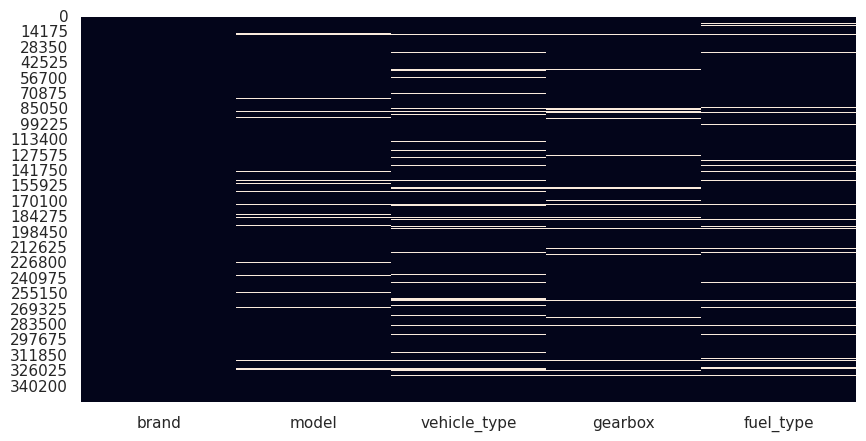

In [12]:
# Выведем карту пропусков в столбцах
sns.set(rc={'figure.figsize': (10, 5)})
sns.heatmap(data[['brand', 'model', 'vehicle_type', 'gearbox', 'fuel_type']].isnull(), cbar=False);

<p>Последовательно заполним пропуски от признака brand до fuel_type.</p>

##### model

<p>Заменим пропуски в столбце model наиболее распространенными значениями для brand.</p>

In [13]:
# Заполним пропуски в model на основе model
data['model'] = data['model'].fillna(data.groupby('brand')['model']
                                                  .transform(lambda x: x.mode()[0] if not x.mode().empty else None))

# Оставшиеся пропуски model заполним brand
data['model'] = data['model'].fillna(data['brand'])

In [14]:
# Проверим число пропусков в столбце model
data['model'].isna().sum()

0

##### vehicle_type

<p>На основе столбца model заполним пропуски в vehicle_type.</p>

In [15]:
# Заполним пропуски в vehicle_type
data['vehicle_type'] = data['vehicle_type'].fillna(data.groupby('model')['vehicle_type']
                                                  .transform(lambda x: x.mode()[0] if not x.mode().empty else None))

In [16]:
# Проверим число пропусков в столбце vehicle_type
data['vehicle_type'].isna().sum()

0

##### gearbox

<p>Заполним пропуски gearbox наиболее распространенными для model.</p>

In [17]:
# Заполним пропуски в gearbox
data['gearbox'] = data['gearbox'].fillna(data.groupby('model')['gearbox']
                                                  .transform(lambda x: x.mode()[0] if not x.mode().empty else None))

In [18]:
# Проверим число пропусков в столбце gearbox
data['gearbox'].isna().sum()

0

##### fuel_type

<p>Заполним пропуски fuel_type наиболее распространенными для model.</p>

In [19]:
# Заполним пропуски в vehicle_type
data['fuel_type'] = data['fuel_type'].fillna(data.groupby('model')['fuel_type']
                                                  .transform(lambda x: x.mode()[0] if not x.mode().empty else None))

In [20]:
# Проверим число пропусков в столбце fuel_type
data['fuel_type'].isna().sum()

0

##### repaired

<p>Определить с достаточной точностью значение каждого из пропущенных значений repaired мы не можем, поэтому заменим наиболее распространенным значением в пайплайне на этапе предобработки данных.</p>

#### Явные дубликаты

<p>Проведем проверку на наличие явных дубликатов.</p>

In [21]:
data.duplicated().sum()

4

<p>Обнаружены явные дубликаты, произведем их удаление.</p>

In [22]:
data = data.drop_duplicates()

#### Неявные дубликаты

<p>Проверим категорийные признаки на предмет наличия неявных дубликатов.</p>

In [23]:
# Выведем число уникальных значений в столбце vehicle_type
print(data['vehicle_type'].nunique())
print(data['vehicle_type'].unique())

8
['sedan' 'coupe' 'suv' 'small' 'convertible' 'bus' 'wagon' 'other']


<p>Неявных дубликатов не обнаружно.</p>

In [24]:
data['registration_month'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

In [25]:
# Заменим значения 0 на None
data.loc[data['registration_month'] == 0, 'registration_month'] = None

In [26]:
# Выведем число уникальных значений в столбце registration_year
print(data['registration_year'].nunique())
print(data.sort_values('registration_year')['registration_year'].unique())

151
[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]


<p>В списке уникальныз значений registration_year есть заведомо ошибочные (слишком ранние и слишком поздние).</p>
<p>Сравним дату регистрации каждого автомобиля (год и месяц) с датами выгрузки анкеты из базы и создания объявления.</p>
<p>Дата регистрации не может быть больше любой из указанных дат. Если дата регистрации больше, используем самую раннюю из двух дат (выгрузки анкеты или создания анкеты).</p>
<p>Самую раннюю дату ограничим 1970 г. Заменим все значения registration_year меньше 1970 на None. В пайплайне заменим None на наиболее распространенные значения.</p>

In [27]:
# Функция сравнивает год регистрации с минимальной из дат date_crawled и date_created
def check_reg_year(x):
    
    if math.isnan(x.registration_month):
        # При отсутствии месяца примем месяц = 6
        reg_month = 6
    else:
        reg_month = int(x.registration_month)
    
    # Дата регистрации из года и месяца регистрации (день - середина месяца)
    reg_date = date(day=15, month=reg_month, year=x.registration_year)
    
    # Минимум из двух дат
    min_crawled_created_date = min(x.date_crawled, x.date_created)
    
    # Сравним дату регистрации с датами создания и выкачки
    if reg_date > min_crawled_created_date.date():
        # Ошибка в годе регистрации, возвращаем год min_crawled_created_date
        return min_crawled_created_date.year
    else:
        return x.registration_year

In [28]:
# Произведем корректировку ошибочно больших значений registration_year
data['registration_year'] = data.apply(lambda x: check_reg_year(x), axis=1)

# Произведем корректировку ошибочно малых значений registration_year
data['registration_year'] = data.apply(lambda x: None if x.registration_year < 1970 
                                                      else x.registration_year, axis=1)

In [29]:
# Выведем число уникальных значений в столбце gearbox
print(data['gearbox'].nunique())
print(data['gearbox'].unique())

2
['manual' 'auto']


In [30]:
# Выведем число уникальных значений в столбце model
print(data['model'].nunique())
print(data.sort_values('model')['model'].unique())

251
['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 'fusion' 'g_klasse' 'galant'
 'galaxy' 'getz' 'gl' 'glk' 'golf' 'grand' 'i3' 'i_reihe' 'ibiza'
 'imprez

<p>Произведем удаление неявных дубликатов.</p>

In [31]:
# Произведем замену неявных дубликатов в столбце model
data['model'] = data['model'].replace('1_reihe', '1er')
data['model'] = data['model'].replace('3_reihe', '3er')
data['model'] = data['model'].replace('5_reihe', '5er')
data['model'] = data['model'].replace('6_reihe', '6er')

<p>Неявные дубликаты удалены.</p>

In [32]:
# Выведем число уникальных значений в столбце fuel_type
print(data['fuel_type'].nunique())
print(data.sort_values('fuel_type')['fuel_type'].unique())

7
['cng' 'electric' 'gasoline' 'hybrid' 'lpg' 'other' 'petrol']


In [33]:
# Произведем замену неявных дубликатов в столбце fuel_type
data['fuel_type'] = data['fuel_type'].replace('cng', 'lpg')
data['fuel_type'] = data['fuel_type'].replace('gasoline', 'petrol')

<p>Неявные дубликаты удалены.</p>

In [34]:
# Выведем число уникальных значений в столбце brand
print(data['brand'].nunique())
print(data.sort_values('brand')['brand'].unique())

40
['alfa_romeo' 'audi' 'bmw' 'chevrolet' 'chrysler' 'citroen' 'dacia'
 'daewoo' 'daihatsu' 'fiat' 'ford' 'honda' 'hyundai' 'jaguar' 'jeep' 'kia'
 'lada' 'lancia' 'land_rover' 'mazda' 'mercedes_benz' 'mini' 'mitsubishi'
 'nissan' 'opel' 'peugeot' 'porsche' 'renault' 'rover' 'saab' 'seat'
 'skoda' 'smart' 'sonstige_autos' 'subaru' 'suzuki' 'toyota' 'trabant'
 'volkswagen' 'volvo']


In [35]:
# Произведем замену неявных дубликатов в столбце fuel_type
data['brand'] = data['brand'].replace('sonstige_autos', 'other')

<p>Замена произведена.</p>

In [36]:
# Выведем число уникальных значений в столбце repaired
print(data['repaired'].nunique())
print(data.sort_values('repaired')['repaired'].unique())

2
['no' 'yes' nan]


<p>Неявные дубликаты не обнаружены.</p>

#### Вывод

<p>В рооцессе предобработки данных было сделано:</p>
<ul>
    <li>Произведено переименование колонок датафрейма.</li>
    <li>Обнаружены пропуски в данных, принято решение о заполнение пропусков в пайплайне на этапе предобработки.</li>
    <li>Обнаружены явные дубликаты, произведено их удаление.</li>
    <li>Произведен поиск и удаление неявных дубликатов в категориальных признаках.</li>
</ul>

### Исследовательский анализ данных

#### Статистический и графический анализ признаков

<p>Проведем статистический и графический анализ признаков.</p>

##### price

In [37]:
data['price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

<p>Минимальное значение цены равно 0, максимальное 20000, среднее 2700.</p>
<p>Выведеи число объявлений с нулевой ценой.</p>

In [38]:
data[data['price'] == 0]['price'].count()

10772

<p>Попытаемся оценить качество автомобилей в объявлениях с нулевой ценой.</p>

In [39]:
# Выведем типичные параметры автомобилей с нулевой ценой по годам
data[data['price'] == 0].groupby('registration_year') \
                        .agg({'kilometer': pd.Series.mean, 
                              'repaired': pd.Series.mode, 
                              'model': pd.Series.mode,
                              'date_crawled': pd.Series.count})

,kilometer,repaired,model,date_crawled
registration_year,,,,
1970.0,75816.326531,no,other,49
1971.0,70000.000000,no,other,8
1972.0,113333.333333,no,"[601, 911, kadett]",3
1973.0,64375.000000,no,other,8
1974.0,85000.000000,no,other,2
1975.0,100833.333333,"[no, yes]",other,6
1976.0,92500.000000,yes,other,18
1977.0,107500.000000,no,other,4
1978.0,69444.444444,no,"[kadett, other]",9


<p>Нулевая цена встречается у достаточно дорогих автомобилей популярных моделей разного года выпуска (в т.ч. почти новых), без проведенного ремонта (вероятно, без аварий и существенных проблем с ключевыми агрегатами). Скорее всего, нулевая цена - результат ошибка при занесении данных или умышленно оставленное пустым поле.</p>
<p>Возможна безвоздмездная передача автомобилей в плохом техническом состоянии или после аварии, в таком случае нулевая цена - это не ошибка, но таких случаев должно быть очень мало, поскольку даже при продаже запчастей можно получить какие-то средства.</p>
<p>Учитывая тот факт, что мы разрабатываем оценочную систему, нулевые значения не будут приносить пользу при обучении модели и реальном ее использовании.</p>
<p>Произведем замену нулевых значений на None, а в пайплайне на этапе преодобработки заменим средним значением.</p>

In [40]:
# Произведем замену нулевых значений в столбце price
data['price'] = data['price'].replace(0, None)

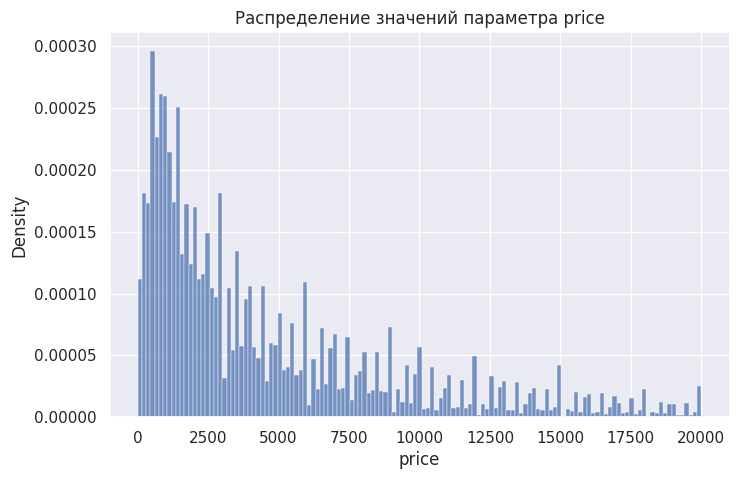

In [41]:
sns.set(rc={'figure.figsize': (8, 5)})
sns.histplot(data=data, x='price',
                        stat='density',
                        common_norm=False).set_title('Распределение значений параметра price');

<p>Распределение не является нормальным, пик смещен влево.</p>

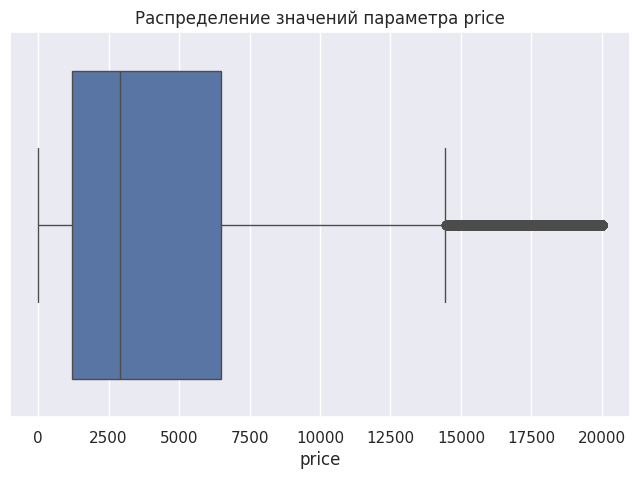

In [42]:
sns.boxplot(x='price', data=data).set_title('Распределение значений параметра price');

##### vehicle_type

In [43]:
data['vehicle_type'].describe()

count     354365
unique         8
top        sedan
freq      109944
Name: vehicle_type, dtype: object

<p>Наиболее распространенный тип кузова - sedan.</p>

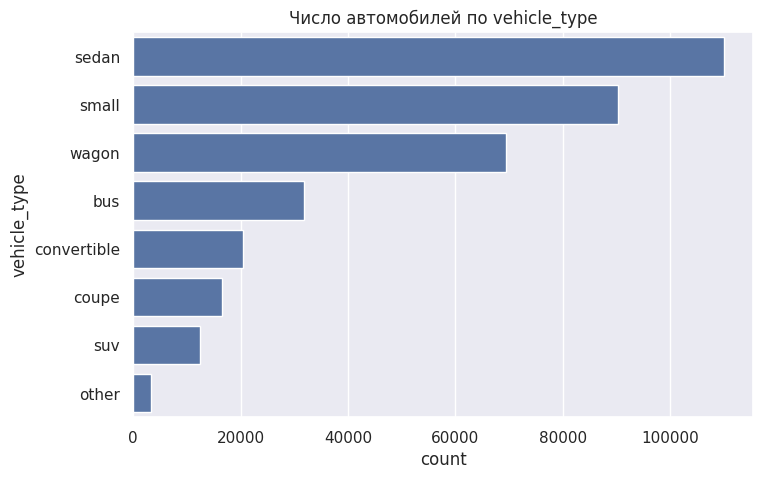

In [44]:
# Выведем график распределения автомобилей по vehicle_type
sns.countplot(y='vehicle_type',
              data=data,
              order=data['vehicle_type'].value_counts().index) \
              .set_title('Число автомобилей по vehicle_type');

##### registration_year

In [45]:
data['registration_year'].describe()

count    353027.000000
mean       2003.201594
std           6.863059
min        1970.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2016.000000
Name: registration_year, dtype: float64

<p>Минимальное значение registration_year равно 1999, максимальное - 2019.</p>

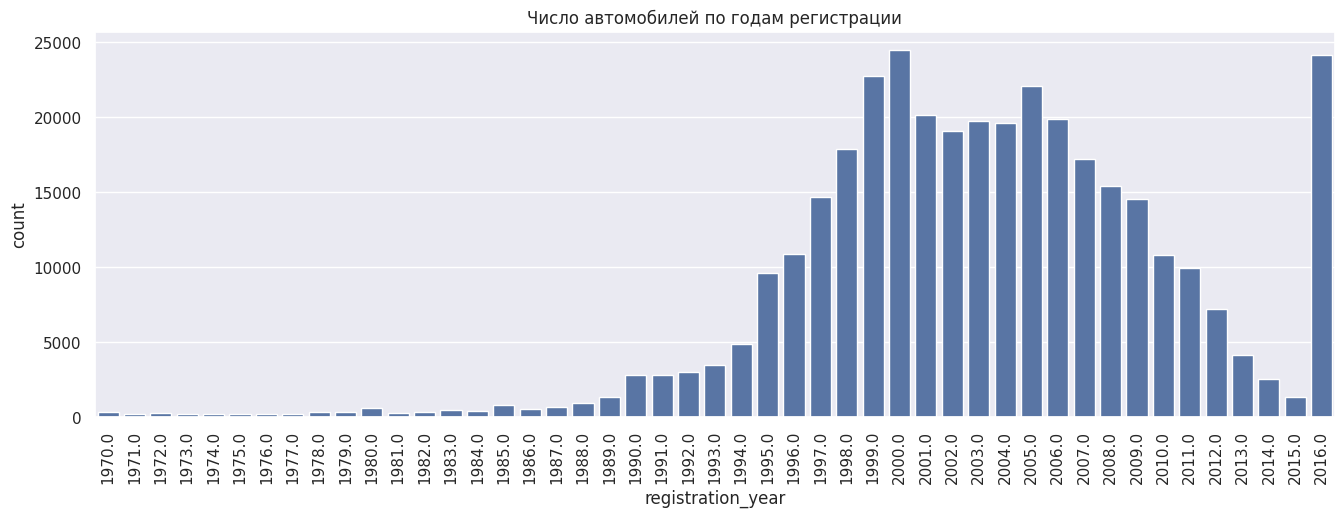

In [46]:
# Выведем график распределения автомобилей по vehicle_type
sns.set(rc={'figure.figsize': (16, 5)})
sns.countplot(x='registration_year',
              data=data) \
              .set_title('Число автомобилей по годам регистрации');
plt.xticks(rotation=90);

<p>Наибольшее число автомобилей зарегистрировано в 2000 г., второй пик в районе 2006 г.</p>

##### gearbox

In [47]:
data['gearbox'].describe()

count     354365
unique         2
top       manual
freq      286284
Name: gearbox, dtype: object

<p>Наиболее распространенная коробка - ручная.</p>

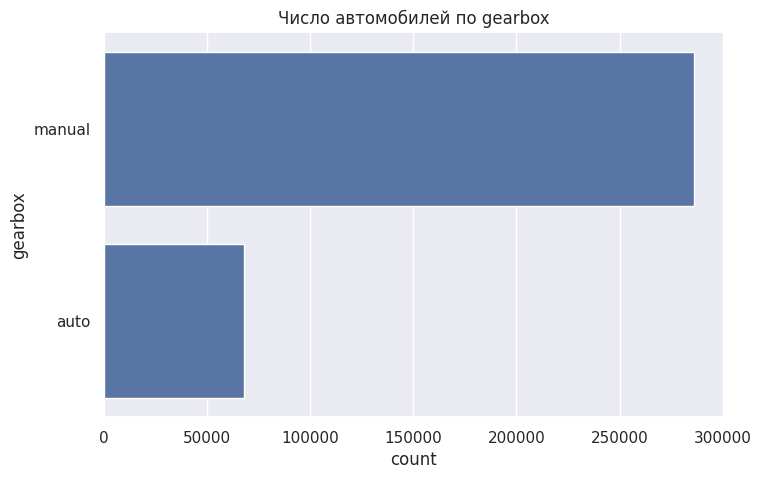

In [48]:
# Выведем график распределения автомобилей по gearbox
sns.set(rc={'figure.figsize': (8, 5)})
sns.countplot(y='gearbox',
              data=data,
              order=data['gearbox'].value_counts().index) \
              .set_title('Число автомобилей по gearbox');

##### power

In [49]:
data['power'].describe()

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

<p>Максимальная мощность равна 20000 л.с., минимальная - 0 л.с. Очевидно, что это ошибочные данные.</p>
<p>Примем за корректное максимальное значение 300 л.с. Большие значения и нулевые заменим на None, которые заменим на средние значения в pipeline.</p>

In [50]:
print(data[(data['power'] > 300) | (data['power'] == 0)]['power'].count())

43730


In [51]:
data.loc[(data['power'] > 300) | (data['power'] == 0), 'power'] = None

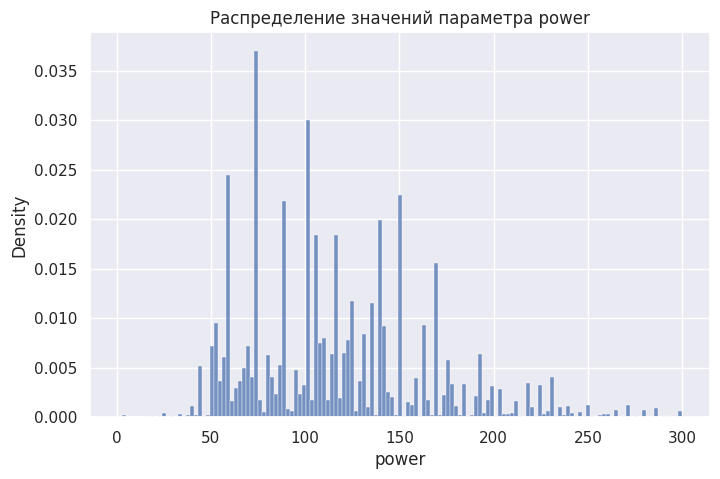

In [52]:
sns.histplot(data=data, x='power',
                        stat='density',
                        common_norm=False).set_title('Распределение значений параметра power');

<p>Видны пики в районе наиболее типичных значений - 75 л.с., 100 л.с., 150 л.с.</p>

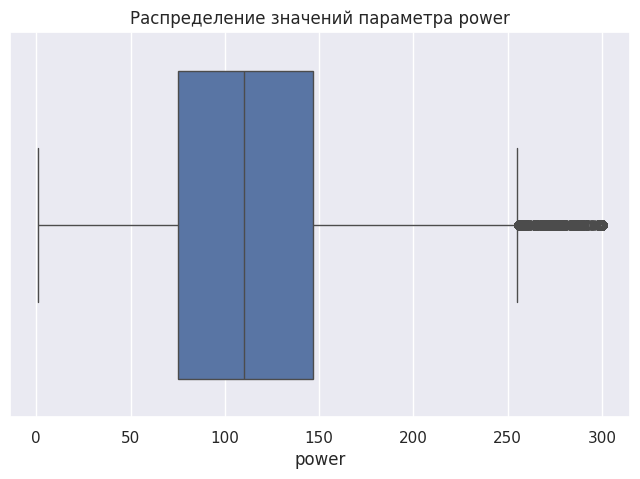

In [53]:
sns.boxplot(x='power', data=data).set_title('Распределение значений параметра power');

##### model

In [54]:
data['model'].describe()

count     354365
unique       247
top         golf
freq       32737
Name: model, dtype: object

<p>Наиболее распространенная модель - golf.</p>

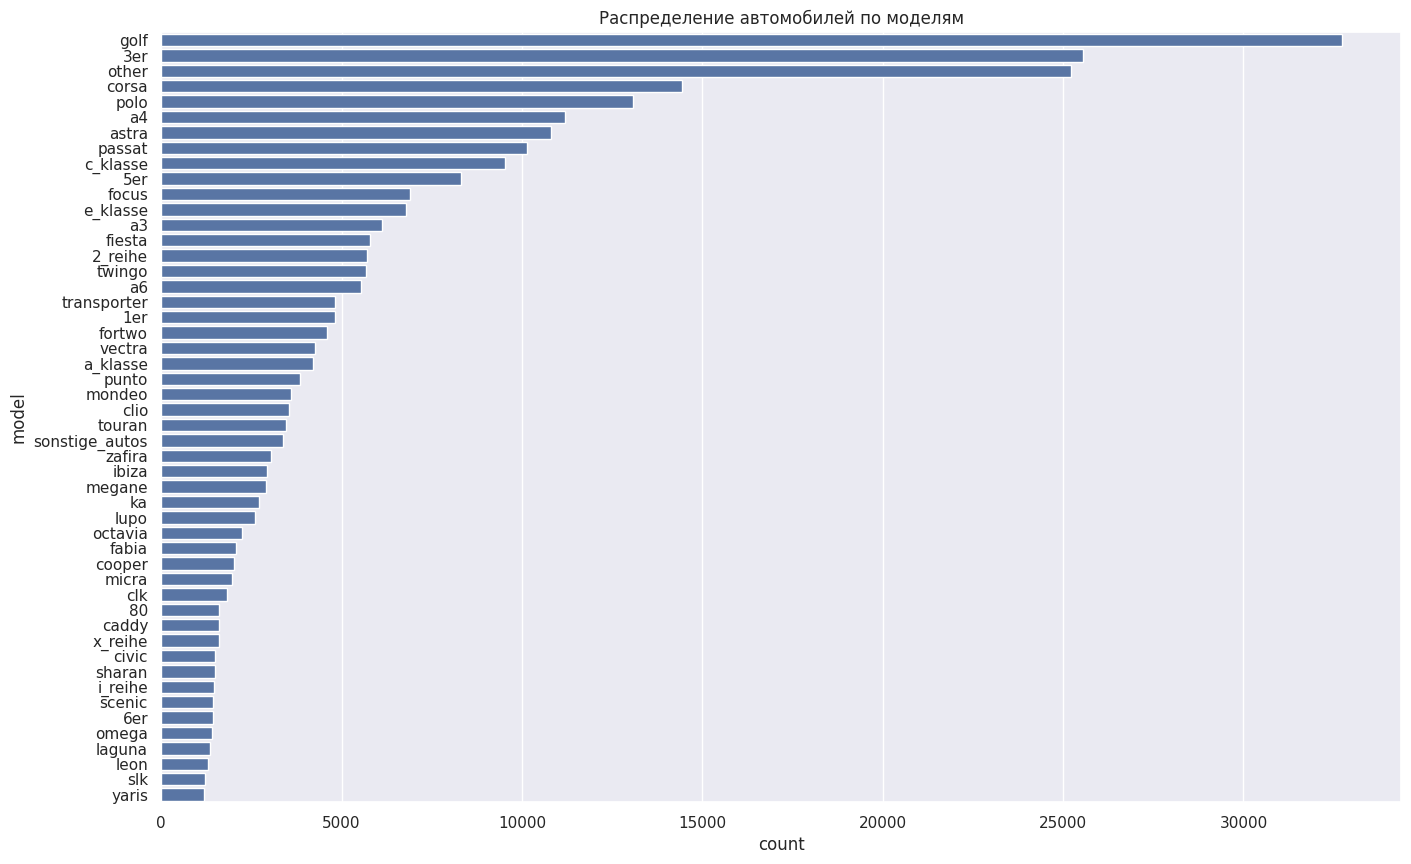

In [55]:
top50_models = data.pivot_table(values='date_crawled', index='model', aggfunc='count')\
                 .rename(columns={'date_crawled': 'count'})\
                 .sort_values('count', ascending=False)[0:50]
# Выведем график распределения автомобилей по vehicle_type
sns.set(rc={'figure.figsize': (16, 10)})

# Выведем график распределения автомобилей по vehicle_type
sns.barplot(data=top50_models, x="count", y=top50_models.index)\
            .set_title('Распределение автомобилей по моделям');

##### kilometer

In [56]:
data['kilometer'].describe()

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

<p>Минимальное значение пробега 5000, максимальное - 150000. При занесении информации пользователю было предложено выбрать одну из категорий.</p>

In [57]:
# Выведем уникальные значения категорий пробега
data['kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000])

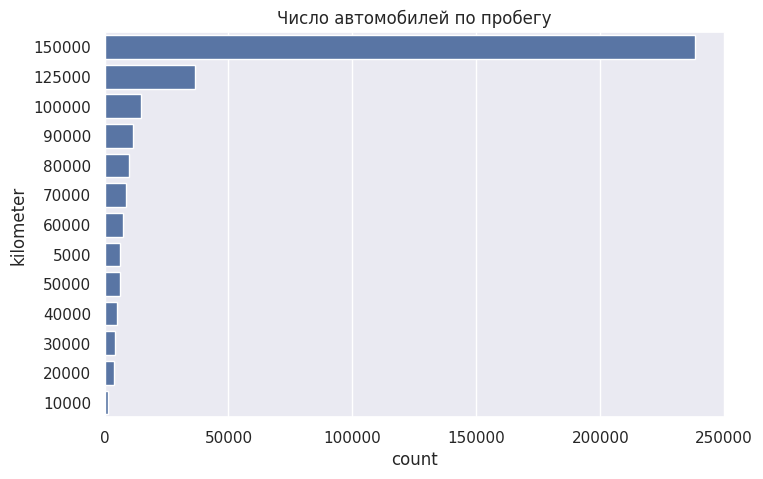

In [58]:
# Выведем график распределения автомобилей по vehicle_type
sns.set(rc={'figure.figsize': (8, 5)})
sns.countplot(y='kilometer',
              data=data,
              order=data['kilometer'].value_counts().index) \
              .set_title('Число автомобилей по пробегу');

<p>Наибольшее число автомобилей с пробегом 150000.</p>

##### registration_month

In [59]:
data['registration_month'].describe()

count    317013.000000
mean          6.387978
std           3.349812
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64

In [60]:
data['registration_month'].unique()

array([nan,  5.,  8.,  6.,  7., 10., 12., 11.,  2.,  3.,  1.,  4.,  9.])

<p>Месяц со значением 0 заменим на None.</p>

In [61]:
# Заменим значения 0 на None
data.loc[data['registration_month'] == 0, 'registration_month'] = None

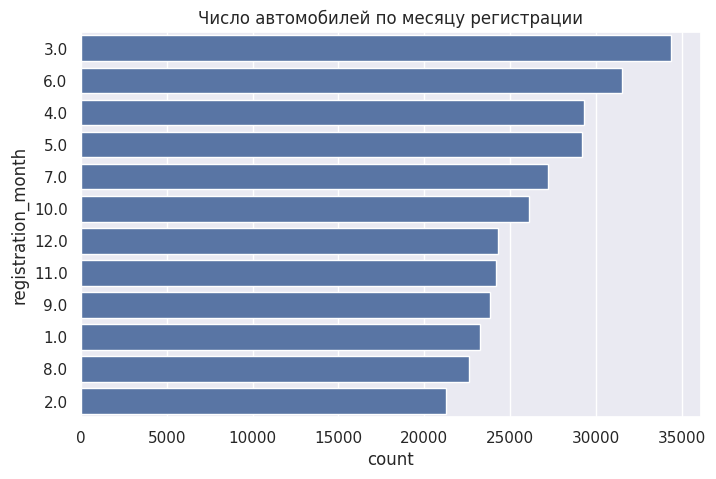

In [62]:
# Выведем график распределения автомобилей по vehicle_type
sns.countplot(y='registration_month',
              data=data,
              order=data['registration_month'].value_counts().index) \
              .set_title('Число автомобилей по месяцу регистрации');

<p>Наибольшее число автомобилей зарегистрировано в марте, наименьшее - в феврале.</p>

##### fuel_type

In [63]:
data['fuel_type'].describe()

count     354365
unique         5
top       petrol
freq      347963
Name: fuel_type, dtype: object

<p>Подавляющее большинство продаваемых автомобилей используют бензин в качестве топлива.</p>

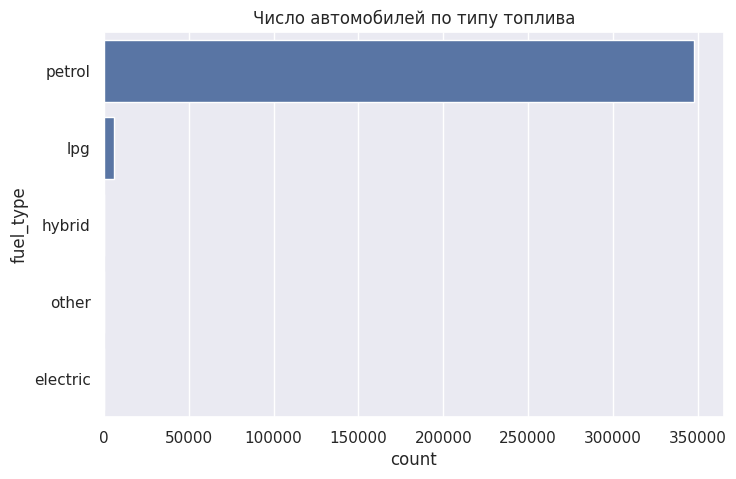

In [64]:
# Выведем график распределения автомобилей по vehicle_type
sns.countplot(y='fuel_type',
              data=data,
              order=data['fuel_type'].value_counts().index) \
              .set_title('Число автомобилей по типу топлива');

##### brand

In [65]:
data['brand'].describe()

count         354365
unique            40
top       volkswagen
freq           77012
Name: brand, dtype: object

<p>Наиболее распространенный бренд - volkswagen.</p>

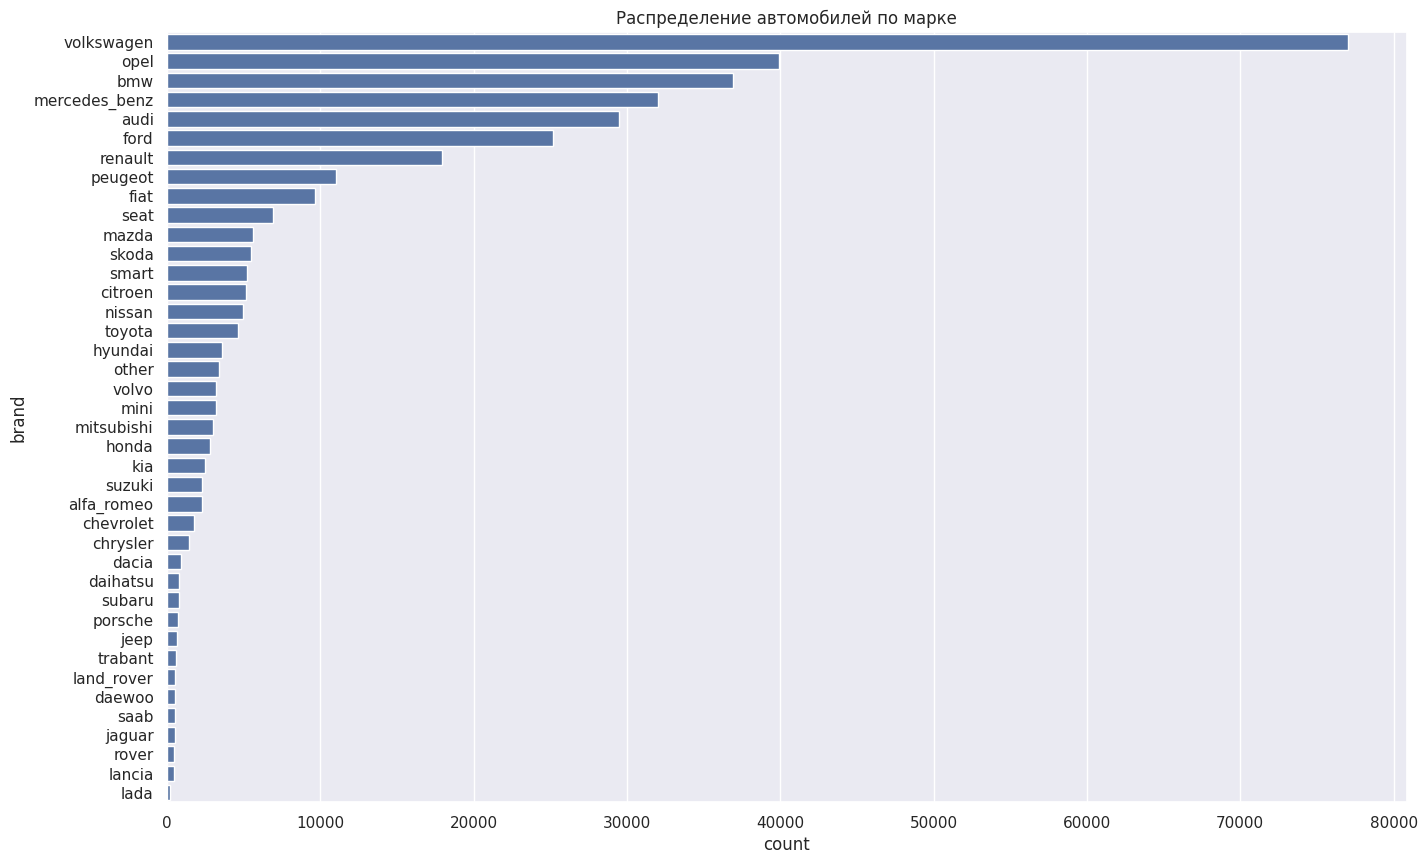

In [66]:
# Выведем график распределения автомобилей по brand
sns.set(rc={'figure.figsize': (16, 10)})
sns.countplot(y='brand',
              data=data,
              order=data['brand'].value_counts().index) \
              .set_title('Распределение автомобилей по марке');

##### repaired

In [67]:
data['repaired'].describe()

count     283211
unique         2
top           no
freq      247158
Name: repaired, dtype: object

<p>Болшая часть автомобилей не была в ремонте (вероятно, капитальном или после аварии).</p>

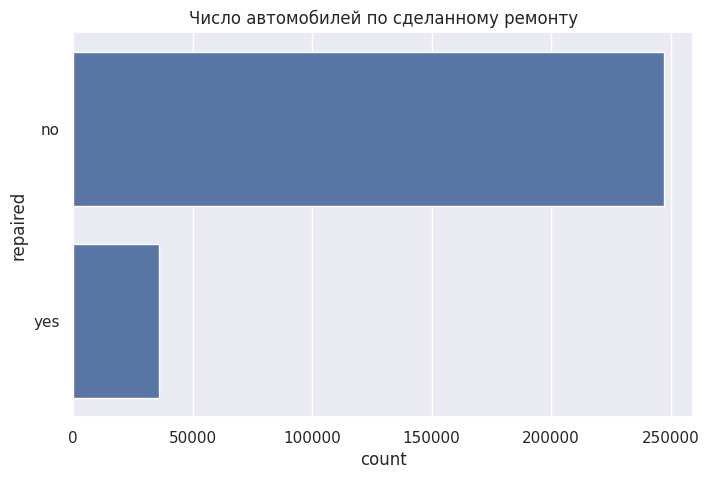

In [68]:
# Выведем график распределения автомобилей по gearbox
sns.set(rc={'figure.figsize': (8, 5)})
sns.countplot(y='repaired',
              data=data,
              order=data['repaired'].value_counts().index) \
              .set_title('Число автомобилей по сделанному ремонту');

##### number_of_pictures

In [69]:
data['number_of_pictures'].describe()

count    354365.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64

In [70]:
data['number_of_pictures'].unique()

array([0])

<p>Данные в столбце отсутствуют, признак не будет использован при обучении модели.</p>

##### postal_code

In [71]:
data['postal_code'].describe()

count    354365.000000
mean      50508.503800
std       25783.100078
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: postal_code, dtype: float64

<p>Максимальное значение равно 99998, минимальное - 1067.</p>
<p>Можно предположить, что формат индекса - число из 5 знаков. Поэтому все индексы, значения которых менеьше 10000, вероятно, начинаются с 0.</p>

In [72]:
# Вычислим количество уникальных значений
data['postal_code'].nunique()

8143

<p>Посмотрим на распределение владельцев анкет по индексам.</p>

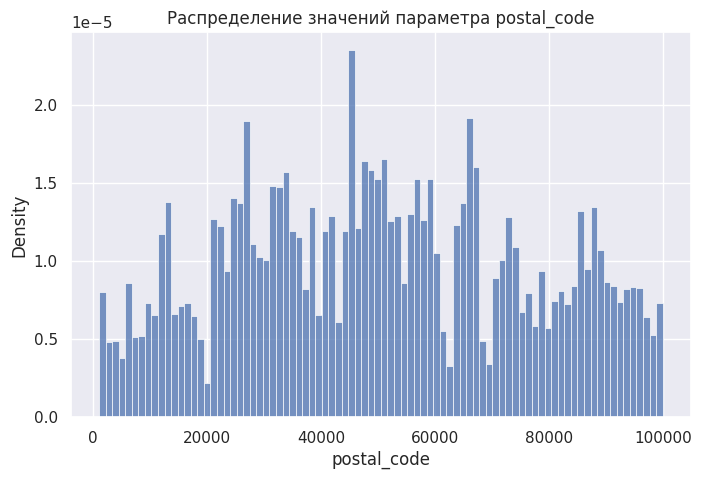

In [73]:
# Выведем график распределения
sns.histplot(data=data, x='postal_code',
                        stat='density',
                        common_norm=False).set_title('Распределение значений параметра postal_code');

<p>На графике распределения можно увидеть деление почтовых индексов на группы примерно с 9 пиками. Можно предположить, что отдельным территориям присвоены индексы с шагом в 10 тыс.</p>
<p>Создадим новый признак, отражающий территориальную характеристику продаваемого автомобиля.</p>
<p>Оставим в новом признаке первую цифру индекса.</p>

In [74]:
# В новом признаке postal_code_region оставим первую цифру postal_code
data['postal_code_region'] = data.apply(lambda x: str(x.postal_code)[0] \
                                                  if len(str(x.postal_code)) == 5 \
                                                  else '0', axis=1)

<p>Посмотрим на распределение объявлений по регионам.</p>

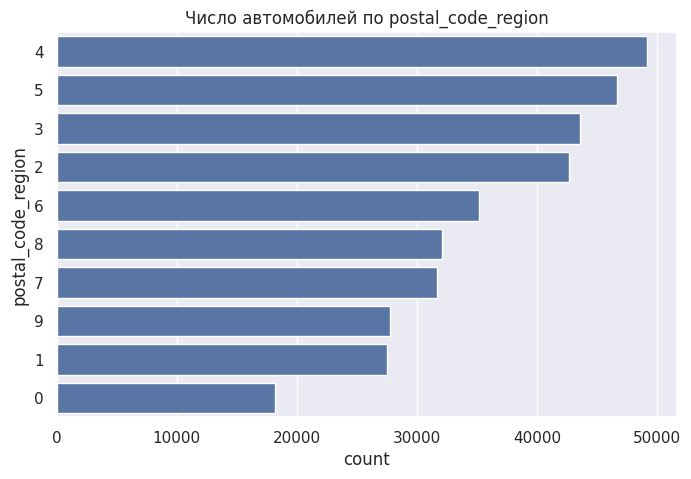

In [75]:
# Выведем число объявлений в каждом регионе
sns.countplot(y='postal_code_region',
              data=data,
              order=data['postal_code_region'].value_counts().index) \
              .set_title('Число автомобилей по postal_code_region');

<p>Наибольшее число объявлений в регионе 4, наименьшее - в регионе 0.</p>
<p>При обучении модели используем признак postal_code_region.</p>

##### last_seen

In [76]:
data['last_seen'].describe()

count                           354365
mean     2016-03-29 23:51:06.766184960
min                2016-03-05 14:15:08
25%                2016-03-23 02:50:03
50%                2016-04-03 15:15:52
75%                2016-04-06 10:15:19
max                2016-04-07 14:58:51
Name: last_seen, dtype: object

<p>Наиболее ранняя дата просмотра объявления - 2016-03-05, наиболее поздняя - 2016-04-07.</p>

### Создание новых признаков

#### reg_days

<p>Создадим новый признак - число дней с даты регистрации до даты выгрузки информации из базы.</p>

In [77]:
# Функция считает число дней с момента регистрации
def registration_days(x):
    registration_year = x['registration_year']
    registration_month = x['registration_month']
    
    if math.isnan(registration_year):
        return None
    
    if math.isnan(registration_month):
        return (x['date_crawled'].date() - date(int(registration_year), 6, 1)).days
    
    return (x['date_crawled'].date() - date(int(registration_year), int(registration_month), 1)).days

In [78]:
data['reg_days'] = data.apply(lambda x: registration_days(x), axis=1)

#### brand_country

<p>Создадим новый признак - страна бренда.</p>

In [79]:
data['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai', 'other',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'toyota', 'chevrolet', 'dacia', 'daihatsu', 'trabant',
       'saab', 'chrysler', 'jaguar', 'daewoo', 'porsche', 'rover',
       'land_rover', 'lada'], dtype=object)

<p>Создадим словарь с брендами и странами.</p>

In [80]:
country_dict = {'volkswagen': 'GER', 'audi': 'GER', 'jeep': 'USA', 'skoda': 'CZE', 'bmw': 'GER', 'peugeot': 'FRA', 'ford': 'USA',
       'mazda': 'JPN', 'nissan': 'JPN', 'renault': 'FRA', 'mercedes_benz': 'GER', 'opel': 'GER', 'seat': 'ESP',
       'citroen': 'FRA', 'honda': 'JPN', 'fiat': 'ITA', 'mini': 'GBR', 'smart': 'GER', 'hyundai': 'KOR',
       'other': 'other', 'alfa_romeo': 'ITA', 'subaru': 'JPN', 'volvo': 'SWE', 'mitsubishi': 'JPN',
       'kia': 'KOR', 'suzuki': 'JPN', 'lancia': 'ITA', 'toyota': 'JPN', 'chevrolet': 'USA', 'dacia': 'ROU',
       'daihatsu': 'JPN', 'trabant': 'GER', 'saab': 'SWE', 'chrysler': 'USA', 'jaguar': 'GBR', 'daewoo': 'KOR',
       'porsche': 'GER', 'rover': 'GBR', 'land_rover': 'GBR', 'lada': 'RUS'}

In [81]:
# Создадим столбец со страной бренда
data['brand_country'] = data.apply(lambda x: country_dict[x.brand], axis=1)

In [82]:
# Выведем статистику по странам брендов
data['brand_country'].describe()

count     354365
unique        13
top          GER
freq      221950
Name: brand_country, dtype: object

<p>Наибольшее число машин в базе немецких брендов.</p>

### Корреляционный анализ

In [83]:
# Количественные признаки
numerical_cols = ['power',
                  'reg_days',
                  'kilometer',
                  'price'
                  ]

# Категорийные признаки
categorical_cols = ['vehicle_type',
                    'gearbox',
                    'model',
                    'fuel_type',
                    'brand',
                    'repaired',
                    'brand_country',
                    'postal_code_region'
                    ]

# Список признаков для проведения корреляционного анализц
phik_cols = numerical_cols + categorical_cols

In [84]:
# вычисление коэффициентов корреляции phi для датафрейма train_features
phik_overview = data[phik_cols].phik_matrix(interval_cols=numerical_cols)

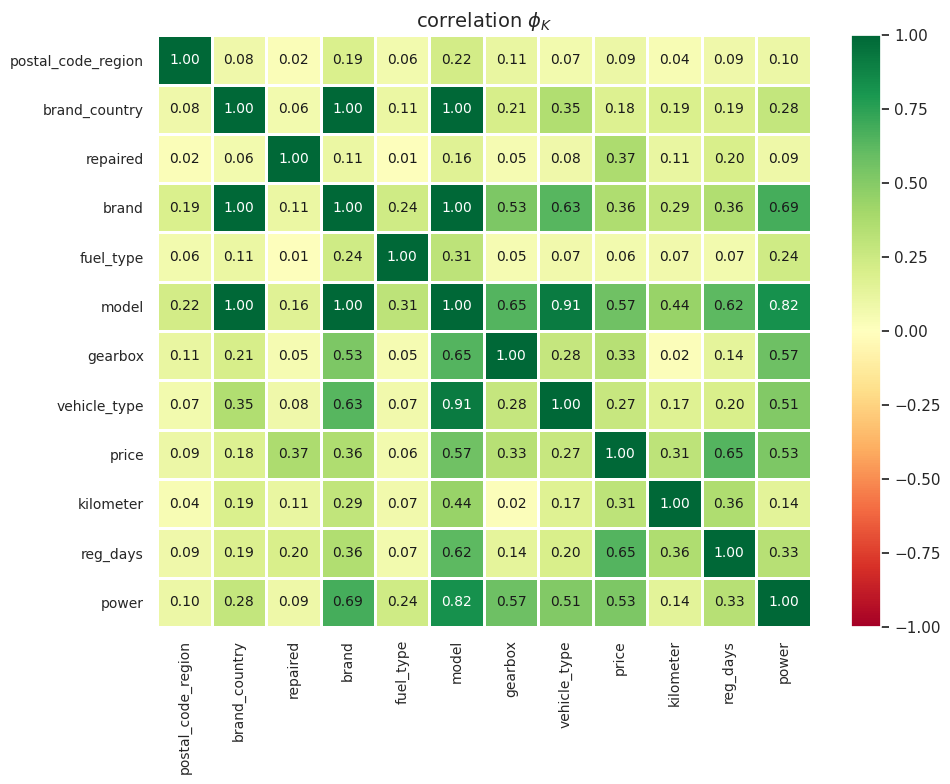

In [85]:
# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1,
    figsize=(10, 8)
)

<p>Заметная и высокая корреляция с таргетом:
    <ul>
        <li>model</li>
        <li>reg_days</li>
        <li>power</li>
    </ul>
</p>

<p>Мультиколлинеарность признаков:
    <ul>
        <li>brand_country - brand</li>
        <li>model - brand</li>
        <li>model - vehicle_type</li>
    </ul>
</p>

### Подготовка данных

#### Списки признаков

<p>Скорректируем списки с категориальными и количественными данными с учетом проведенного корреляционного анализа.</p>
<p>Для устранения влияния мультиколлинеарности оставим в списке признаков model (имеет наибольшую корреляцию с таргетом).</p>
<p>Кроме того, не будем использовать при обучении признак postal_code, являющийся категорийным и содержащим очень большое количество значений. Используем синтетический признак postal_code_region.</p>

In [86]:
# Количественные признаки
numerical_cols = ['power',
                  'reg_days',
                  'kilometer'
                  ]

# Категорийные признаки
categorical_cols = ['gearbox',
                    'model',
                    'fuel_type',
                    'repaired',
                    'postal_code_region'
                    ]

# Таргет
target = 'price'

# Полный входных список признаков
model_cols = numerical_cols + categorical_cols

#### Разделение признаков

<p>Проведем разделение признаков на входные и целевой признак.</p>

In [87]:
# Входные и целевой признаки
X = data[model_cols]
y = data[target]

#### Создание выборок

<p>Разделим датасеты на обучающую и валидационную выборки с учетом TEST_SIZE.</p>

In [88]:
# Обучающая и тестовая выбоки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

#### Предобработка таргета

In [89]:
# Среднее значение таргета для обучающей выборки
mean_price = y_train.mean()

# Произведем замену пропусков средним значением обучающей выборки
y_train = y_train.fillna(mean_price)
y_test = y_test.fillna(mean_price)

### Освобождение памяти

In [90]:
# Освободим память
del data
del phik_overview
del X
del y

## Обучение моделей

#### Создание пайплайнов

In [91]:
# создаём пайплайн для подготовки признаков из списка numerical_cols
num_pipe = Pipeline(
    [('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
     ('num', MinMaxScaler())
    ]
)

In [92]:
# создаём пайплайн для подготовки признаков из списка categorical_cols
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

# создаём пайплайн для подготовки признаков из списка categorical_cols
cat_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('target_encoder', TargetEncoder(random_state=RANDOM_STATE))
    ]
)

In [93]:
# создаём общий пайплайн для подготовки данных с num и ohe
data_preprocessor = ColumnTransformer(
    [('num', num_pipe, numerical_cols),
     ('ohe', ohe_pipe, categorical_cols)
    ], 
    remainder='passthrough'
)

# создаём еще один пайплайн для подготовки данных с Imputer и TargetEncoder
data_preprocessor_cat = ColumnTransformer(
    [('num', num_pipe, numerical_cols),
     ('cat', cat_pipe, categorical_cols)
    ], 
    remainder='passthrough'
)

In [94]:
# создаём итоговые пайплайны для моделей для обучения в цикле
pipelines = [
    Pipeline([
              ('preprocessor', data_preprocessor_cat),
              ('models', LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1, verbose_eval=False))
             ]),

    Pipeline([
              ('preprocessor', data_preprocessor),
              ('models', SGDRegressor(random_state=RANDOM_STATE, verbose=0))
             ]),

    Pipeline([
              ('preprocessor', data_preprocessor),
              ('models', BayesianRidge(verbose=False))
             ]),

    Pipeline([
              ('preprocessor', data_preprocessor_cat),
              ('models', xgb.XGBRegressor(verbose=False))
             ])
]

<p>Вузиализируем пайплайны для каждой из моделей.</p>

In [95]:
# Пайплайн для модели LGBMRegressor
set_config(display="diagram")
pipelines[0]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer()),
                                                                  ('num',
                                                                   MinMaxScaler())]),
                                                  ['power', 'reg_days',
                                                   'kilometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   TargetEncoder(random_state=42))]),
                                                  ['gearbox', 'model',
                                                   'fuel_type', 'repaired',
                                                   'postal_code_region'])])),
                ('models',
                 LGBMRegressor(random_state=42, verbose_eval=False,
                               verbosity=-1))])

In [96]:
# Пайплайн для модели SGDRegressor
pipelines[1]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer()),
                                                                  ('num',
                                                                   MinMaxScaler())]),
                                                  ['power', 'reg_days',
                                                   'kilometer']),
                                                 ('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gearbox', 'model',
                                                   'fuel_type', 'repaired',
                                                   'postal_code_region'])])),
                ('models', SGDRegressor(random_state=42))])

In [97]:
# Пайплайн для модели BayesianRidge
pipelines[2]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer()),
                                                                  ('num',
                                                                   MinMaxScaler())]),
                                                  ['power', 'reg_days',
                                                   'kilometer']),
                                                 ('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gearbox', 'model',
                                                   'fuel_type', 'repaired',
                                                   'postal_code_region'])])),
                ('models', BayesianRidge())])

In [98]:
# Пайплайн для модели XGBRegressor
pipelines[3]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer()),
                                                                  ('num',
                                                                   MinMaxScaler())]),
                                                  ['power', 'reg_days',
                                                   'kilometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   TargetEncoder(random_state=42))]),
                                                  ['gea...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

#### Создание параметров

In [99]:
# Названия моделей для вывода в таблице результатов
names = ['LGBMRegressor', 'SGDRegressor', 'BayesianRidge', 'XGBRegressor']

In [100]:
# Словари с гиперпараметрами
parameters = [
              # LGBMRegressor
              {
               'models__learning_rate': distributions.FloatDistribution(0.1, 1),
               'models__num_leaves': distributions.IntDistribution(2, 10),
               'models__max_depth': distributions.IntDistribution(5, 15),
               'models__n_estimators': distributions.IntDistribution(100, 300)
              },
              # SGDRegressor
              {
               'models__alpha': distributions.FloatDistribution(0.001, 0.1),
               'models__max_iter': distributions.IntDistribution(100, 1000)
              },
              # BayesianRidge
              {
               'models__max_iter': distributions.IntDistribution(100, 300),
               'models__alpha_1': distributions.FloatDistribution(1.e-6, 1.e-5),
               'models__alpha_2': distributions.FloatDistribution(1.e-6, 1.e-5),
              },
              # XGBRegressor
              {
               'models__learning_rate': distributions.FloatDistribution(0.1, 1),
               'models__max_leaves': distributions.IntDistribution(2, 10),
               'models__max_depth': distributions.IntDistribution(5, 15),
               'models__n_estimators': distributions.IntDistribution(100, 300)
              }
]

#### Поиск параметров

In [101]:
# Отключим лог при подборе гиперпараметров
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Функция обучения и предсказания
def optim_func(name, parameters, model, X_train, y_train):

    # Инициализируем класс поиска на 20 итераций
    oscv = OptunaSearchCV(
        model, 
        parameters, 
        cv=5,
        n_trials=20,
        scoring='neg_root_mean_squared_error',
        random_state=RANDOM_STATE,
        verbose=0
    )

    # Запускаем поиск гиперпараметров
    oscv.fit(X_train, y_train)

    # Сохраняем лучшую модель
    best_model = oscv.best_estimator_
    
    # Сохраняем лучшую метрику
    best_metrix = oscv.best_score_
    
    # Время обучения лучшей модели
    fit_time = oscv.refit_time_

    # Запуск таймера
    start = time.time()

    # Выполняем предсказание на тестовых данных
    oscv.predict(X_train)

    # Вычисление времени
    pred_time = time.time() - start
    
    return {'name': name, 'rmse': best_metrix, 'fit_time': fit_time, 'predict_time': pred_time, 'best_model': best_model}

In [102]:
# Список для вывода результатов обучения по моделям
results = []

# Запускаем обучение для каждой модели
for name, parameter, model in zip(names, parameters, pipelines):
    result = optim_func(name, parameter, model, X_train[model_cols], y_train)
    results.append(result)

In [103]:
# Выведем таблицу с результатми
res = pd.DataFrame(results)

# Модель максимизировала отрицательный rmse, приведем значения rmse к нормальному виду
res['rmse'] = res['rmse'] * (-1)
res.sort_values('rmse', ascending=True)

,name,rmse,fit_time,predict_time,best_model
0,LGBMRegressor,1989.302596,3.018478,1.035187,"(ColumnTransformer(remainder='passthrough',\n ..."
3,XGBRegressor,2009.187630,4.792389,0.754400,"(ColumnTransformer(remainder='passthrough',\n ..."
2,BayesianRidge,2957.524357,40.649279,1.859758,"(ColumnTransformer(remainder='passthrough',\n ..."
1,SGDRegressor,3009.676975,24.922478,1.885509,"(ColumnTransformer(remainder='passthrough',\n ..."


<p>Две модели - SGDRegressor и BayesianRidge, не достигли нужного значения целевой метрики rmse (менее 2500).</p>
<p>Из оставшихся (обе - модели бустинга) наилучшие показатели по метрике RMSE и времени обучения зафиксированы у LGBMRegressor.</p>
<p>Время предсказания у модели LGBMRegressor больше времени XGBRegressor, однако абсолютная разница мала.</p>
<p><b>Заказчику будет рекомендовано использовать LGBMRegressor.</b></p>

<p>Выведем параметры лучшей модели.</p>

In [104]:
# Параметры лучшей модели LGBMRegressor
results[0]['best_model'].named_steps['models']

LGBMRegressor(learning_rate=0.6658167457766441, max_depth=13, n_estimators=274,
              num_leaves=8, random_state=42, verbose_eval=False, verbosity=-1)

#### Вывод

<p>В процессе обучения модеи было сделано:</p>
<ul>
    <li>Созданы пайплайны для моделей.</li>
    <li>Созданы списки гиперпараметров для каждой модели.</li>
    <li>Произведен подбор параметров для моделей.</li>
    <li>Выбрана лучшая модель и параметры, обеспечивающие наилучшее соотношений значений метрик и времени обучения/предсказания.</li>
</ul>

## Анализ моделей

#### Проверка лучшей модели на тестовой выборке

<p>Проверим качество выбранной лучшей модели на тестовой выборке.</p>

In [105]:
# Выполним предсказание на тестовых данных
y_test_pred = results[0]['best_model'].predict(X_test)

<p>Посчитаем значение метрики RMSE для тестовой выборки.</p>

In [106]:
# Вычисляем метрику
root_mean_squared_error(y_test, y_test_pred)

1992.5621355885246

<p>На тестовой выборке лучшая модель показала значение метрики rmse примерно равное значению на кросс-валидации. Переобучения не произошло.</p>

### График рассеяния таргета

<p>Отобразим график рассеяния таргета для визуализации качества предсказаний.</p>

In [107]:
# Создадим датафрейм с инстинными и предсказанными таргетами
targets = pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

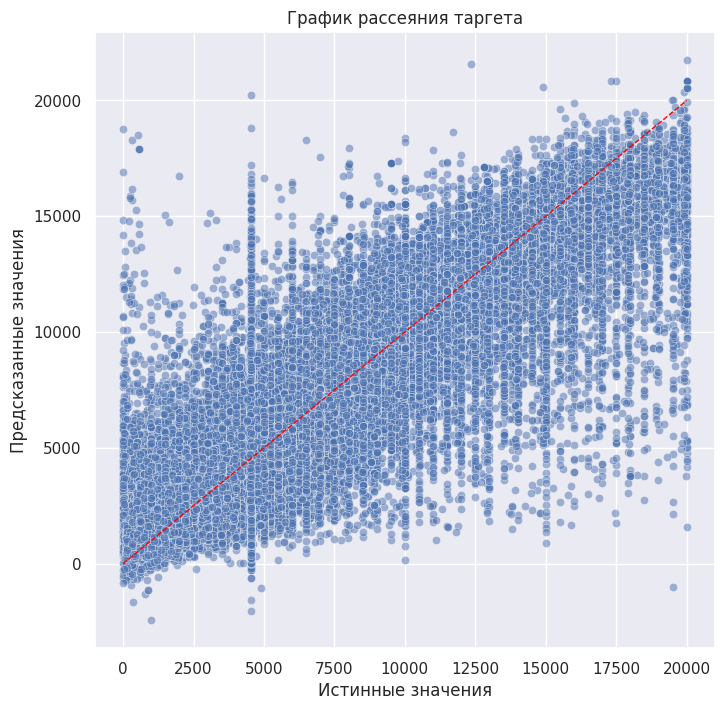

In [108]:
# Выведем диаграмму рассеяния таргета и предсказаний
sns.set(rc={'figure.figsize': (8, 8)})
ax = sns.scatterplot(data=targets, x=y_test, y=y_test_pred, alpha=0.5)
ax.set_xlabel('Истинные значения')
ax.set_ylabel('Предсказанные значения')
ax.set_title('График рассеяния таргета')
x = [0,20000]
plt.plot(x, x, color='red', ls='--', lw=1)
plt.show()

<p>Видно, что модель завышает прогноз таргета в области низких значений цены.</p>
<p>Начиная с середины ценового диапазона появляются сильно зниженные прогнозы.</p>
<p>В районе цены 4500 виден результат заполнения нулевых цен средними значениями. Вероятно, стоило использовать подход, учитывающий параметры машины при заполнении нулевых значений таргета.</p>

### Анализ важности признаков

<p>Выведем наиболее значимые факторы и направления их влияния.</p>

In [109]:
# Сохраним лучшую модель для проведения дальнейшего анализа
model = results[0]['best_model'].named_steps['models']

# Сохраним препроцессор
preprocessor = pipelines[0].named_steps['preprocessor']

# Выполним подготовку тренировочной выборки
X_train_preprocessed = preprocessor.fit_transform(X_train[model_cols], y_train)

# Создадим экземпляр Explainer
explainer = shap.TreeExplainer(model, X_train_preprocessed)

# Получим названия признаков
feature_names = preprocessor.get_feature_names_out()

# Создадим датафрейм
df = pd.DataFrame(X_train_preprocessed, columns=feature_names)

# Рассчитаем значение SHAP
shap_values = explainer(df)

100%|===================| 265495/265773 [09:06<00:00]        

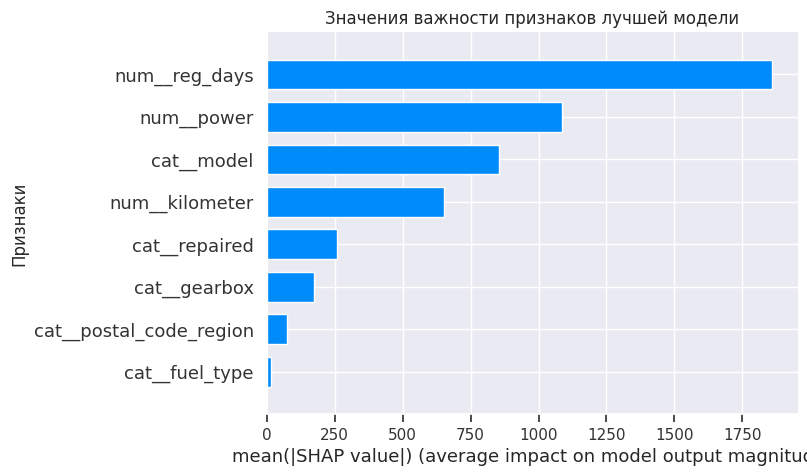

In [110]:
# Построим диаграмму значимости признаков
shap.summary_plot(shap_values, df, plot_type='bar', show=False)
plt.title('Значения важности признаков лучшей модели')
plt.ylabel('Признаки')
plt.show()

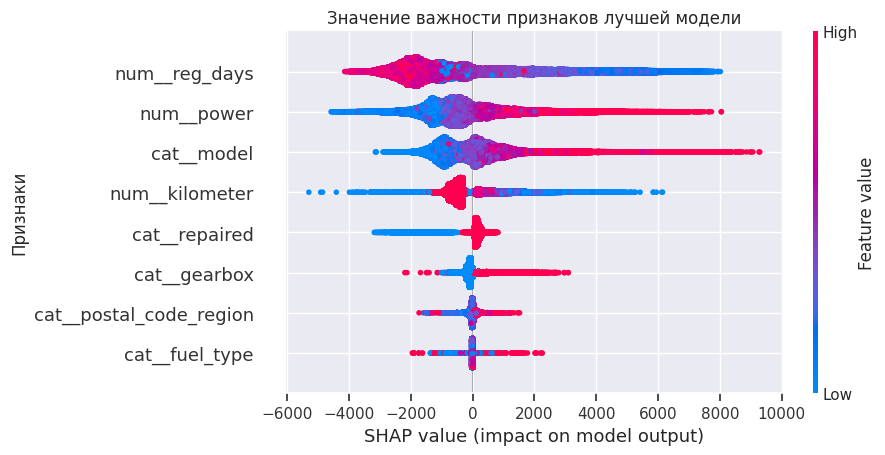

In [111]:
# Выведем диаграмму beeswarm
shap.plots.beeswarm(shap_values, show=False)
plt.title('Значение важности признаков лучшей модели')
plt.ylabel('Признаки')
plt.show()

<p>Метод SHAP выделил следующие ключевые признаки:</p>
<ul>
    <li>Число дней с даты регистрации (меньше дней - больше цена).</li>
    <li>Мощность двигателя - (выше мощность - выше цена).</li>
    <li>Модель машины.</li>
    <li>Пробег (большой пробег - ниже цена).</li>
    <li>Проведенный ремонт.</li>
    <li>Регион.</li>
    <li>Тип коробки передач.</li>
    <li>Тип топлива.</li>
</ul>

## Выводы

<p>В ходе выполнения проекта были выполнены следующие шаги:</p>
<ul>
    <li>Произведена загрузка необходимых библиотек.</li>
    <li>Произведена загрузка данных.</li>
    <li>Произведена предобработка данных (удалены пропуски,явные и неявные дубликаты).</li>
    <li>Проведен статистический и графический анализ данных.</li>
    <li>Проведен корреляционный анализ. Выявлены признаки со значительной связью с таргетом, мультиколлинеарные признаки.</li>
    <li>Принято решение о наборе признаков, на которых будет проводиться обучение модели.</li>
    <li>Произведено разделение данных на обучающую и тестовую выборки.</li>
    <li>Подготовлен пайплайн, выбраны модели и параметры для обучения моделей.</li>
    <li>Произведен поиск лучших параметров для моделей.</li>
    <li>Определена лучшая модель по сумме параметров (метрика rmse, время обучения,время предсказания). Лучшая модель для данной задачи - LGBMRegressor.</li>
    <li>Проведен визуальный анализ диаграммы рассеяния таргета.</li>
    <li>Проведен анализ значимости факторов. Наиболее значимы: число дней с даты регистрации автомобиля (меньше дней - выше цена), мощность двигателя (выше мощность - выше цена), модель машины, пробег (большой пробег - ниже цена).</li>
</ul>